In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preprocessing

In [3]:
import os

In [4]:
data = pd.DataFrame()
for file in os.listdir('pltv_data/'):
    if file != '.DS_Store':
         data = pd.concat([data, pd.read_csv('pltv_data/' + file)])

In [5]:
data.head()

,activity_kind,adid,city,created_at,device_manufacturer,event_name,language,os_name,os_version,revenue_usd_cents
0,event,a410010d8f14b80deaf3fabd9ed13966,Dubai,1622737562,Apple,View vendor List,en,ios,14.4.2,NaN
1,event,25e2086aae280a8547fa47a2e23b45f2,Erbil,1622736728,Apple,View vendor List,en,ios,14.5.1,NaN
2,event,563c7d548e7046a3935c8e9df5a57107,Manama,1622736801,Apple,Launch,en,ios,14.4.2,NaN
3,event,f68155a8067a17deff22a5a29adf2725,Doha,1622737468,Apple,View vendor List,en,ios,14.4.2,NaN
4,session,09f5d37d46843503b8616b6286ad5771,Manama,1622738797,Apple,NaN,en,ios,14.4.2,NaN


In [6]:
len(data)

3123864

We have logs from Apr 5 2021 till Jun 7 2021:

In [7]:
data['created_at'].min(), data['created_at'].max()

(1617640185, 1623110370)

First of all, we don't need data about customers who had no events before June 3 2021 (because we don't know their day 5 user value)

In [8]:
june_3 = 1622678400
data = data.merge(pd.DataFrame(data[data['created_at'] < june_3]['adid']).drop_duplicates())

Now for remaining customers let's use only first 5 days events

In [9]:
data = data.merge(data.groupby('adid')['created_at'].min().reset_index().rename(columns={'created_at': 'first_activity_at'}))
data['time'] = data['created_at'] - data['first_activity_at']
data.drop(['created_at', 'first_activity_at'], axis=1, inplace=True)
data = data[data['time'] <= 5 * 24 * 60 * 60]

In [10]:
data.head()

,activity_kind,adid,city,device_manufacturer,event_name,language,os_name,os_version,revenue_usd_cents,time
0,event,563c7d548e7046a3935c8e9df5a57107,Manama,Apple,Launch,en,ios,14.4.2,NaN,181424
1,event,563c7d548e7046a3935c8e9df5a57107,Manama,Apple,View vendor List,en,ios,14.4.2,NaN,181454
2,event,563c7d548e7046a3935c8e9df5a57107,Manama,Apple,View vendor List,en,ios,14.4.2,NaN,181450
3,event,563c7d548e7046a3935c8e9df5a57107,Manama,Apple,Launch,en,ios,14.4.2,NaN,0
4,event,c1c08ba5c4aaef69d144959d3f2c7ec3,Kuwait City,Apple,nfv_add_to_cart,en,ios,14.3,NaN,183757


In [11]:
len(data)

1530695

# Data exploration

Let's first look at the data

In [12]:
data['activity_kind'].value_counts()

event      1441510
session      88373
install        812
Name: activity_kind, dtype: int64

In [13]:
data['event_name'].value_counts()

View vendor List        838596
View vendor             220815
Add To Cart             162744
Launch                  100675
nfv_add_to_cart          41726
Proceed to Checkout      40463
Order                    32070
view_deals                1207
Order Rate                 756
Voucher Rejected           612
dwh_acquisition            573
Social Log in              393
Log in                     320
Order with Voucher         234
Real Acquisition           211
Sign up                     97
nfv_real_acquisition        14
nfv_order                    4
Name: event_name, dtype: int64

In [14]:
data['city'].value_counts()

Kuwait City     556693
Dubai           133880
Doha            125642
Muscat          122611
Abu Dhabi        98153
                 ...  
Jacksonville         1
Odenton              1
Nuuk                 1
Cainta               1
Al Ansab             1
Name: city, Length: 732, dtype: int64

In [15]:
data['device_manufacturer'].value_counts()

Apple    1530104
Name: device_manufacturer, dtype: int64

In [16]:
data['language'].value_counts()

en    1529928
ar        766
zh          1
Name: language, dtype: int64

In [17]:
data['os_name'].value_counts()

ios    1530695
Name: os_name, dtype: int64

So, basically, 'os_name' and 'device_manufacturer' are useless

In [18]:
data.drop(['device_manufacturer', 'os_name'], axis=1, inplace=True)

In [19]:
data['os_version'].value_counts()

14.4.2    687305
14.5.1    235163
14.6      149048
14.4      108612
14.4.1     67310
           ...  
10.0           3
10.3           2
11.2.0         2
11.1.0         1
9.3.5          1
Name: os_version, Length: 113, dtype: int64

In [20]:
data['revenue_usd_cents'].describe()

count    32074.000000
mean      1734.275587
std       1422.664475
min         14.104372
25%        901.878892
50%       1345.410913
75%       2111.191643
max      36621.261336
Name: revenue_usd_cents, dtype: float64

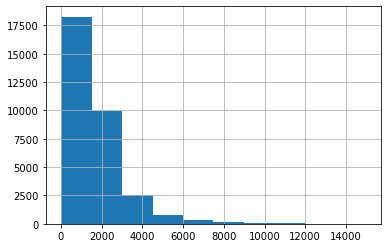

In [21]:
data[data['revenue_usd_cents'] < 15000]['revenue_usd_cents'].hist()

In [22]:
data[~data['revenue_usd_cents'].isna()].head()

,activity_kind,adid,city,event_name,language,os_version,revenue_usd_cents,time
248,event,758c1b288b7bd0c903614833ffeecf25,Dubai,Order,en,14.4.2,925.648635,419251
313,event,c9558ac278ffa382ecd09c9927b43e2a,Muscat,Order,en,14.4,545.457379,367928
341,event,5bd1e87f7b3bff1a305fb273c6d33ce9,Cairo,Order,en,14.4,467.082900,1604
350,event,5bd1e87f7b3bff1a305fb273c6d33ce9,Cairo,Order,en,14.4,348.976811,410258
357,event,53e269d154aacfeb40f81d8ba7b6beef,Kuwait City,Order,en,14.4.2,2244.269632,822


In [23]:
data[data['adid']=='758c1b288b7bd0c903614833ffeecf25'].sort_values(by='time')

,activity_kind,adid,city,event_name,language,os_version,revenue_usd_cents,time
253,event,758c1b288b7bd0c903614833ffeecf25,Dubai,View vendor,en,14.4.2,NaN,0
251,event,758c1b288b7bd0c903614833ffeecf25,Dubai,View vendor List,en,14.4.2,NaN,6
249,event,758c1b288b7bd0c903614833ffeecf25,Dubai,View vendor List,en,14.4.2,NaN,65
252,event,758c1b288b7bd0c903614833ffeecf25,Dubai,View vendor,en,14.4.2,NaN,169
250,event,758c1b288b7bd0c903614833ffeecf25,Dubai,View vendor List,en,14.4.2,NaN,226
244,event,758c1b288b7bd0c903614833ffeecf25,Sharjah,View vendor List,en,14.4.2,NaN,185078
245,event,758c1b288b7bd0c903614833ffeecf25,Sharjah,Add To Cart,en,14.4.2,NaN,185095
247,event,758c1b288b7bd0c903614833ffeecf25,Dubai,View vendor List,en,14.4.2,NaN,419105
246,event,758c1b288b7bd0c903614833ffeecf25,Dubai,View vendor,en,14.4.2,NaN,419107
248,event,758c1b288b7bd0c903614833ffeecf25,Dubai,Order,en,14.4.2,925.648635,419251


# Feature engineering 

All features could be divided into 3 groups:
    - money customer spent within first 24 hours (total amount, number of transactions, median transaction)
    - ones related to customer's activity (how many events, was there install or not, how many sessions, what kind of events)
    - personal data (city, language, os_version)

In [24]:
features = pd.DataFrame(data.groupby('adid')['revenue_usd_cents'].sum()).rename(columns={
    'revenue_usd_cents': '5day_value'})

In [25]:
data_24 = data[data['time'] <= 24 * 60 * 60]

In [26]:
features = features.merge(pd.DataFrame(data_24.groupby('adid')['revenue_usd_cents'].sum()).rename(columns={
    'revenue_usd_cents': '24h_value'}), how='left', on='adid')

In [27]:
features = features.merge(pd.DataFrame(data_24.groupby('adid')['revenue_usd_cents'].count()).rename(columns={
    'revenue_usd_cents': 'transactions_cnt'}), how='left', on='adid')

In [28]:
features = features.merge(pd.DataFrame(data_24.groupby('adid')['revenue_usd_cents'].median()).rename(columns={
    'revenue_usd_cents': 'median_transaction'}).fillna(value=0), how='left', on='adid')

In [29]:
tmp = pd.pivot_table(pd.DataFrame(data_24.groupby(['adid', 'activity_kind'])['time'].count()), 
                     values='time', index='adid', columns='activity_kind')
tmp = tmp.fillna(value=0).rename(columns={'event' : 'event_cnt', 'install' : 'install_cnt', 'session': 'session_cnt'})
features = features.merge(tmp, how='left', on='adid')

In [30]:
tmp = pd.pivot_table(pd.DataFrame(data_24.groupby(['adid', 'event_name'])['time'].count()), 
               values='time', index='adid', columns='event_name').fillna(value=0.)
features = features.merge(tmp, how='left', on='adid').fillna(value=0.)

In [31]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [32]:
tmp = data_24[data_24['time']==0][['adid', 'language', 'os_version']].drop_duplicates()
tmp = pd.concat([tmp.reset_index().drop('index', axis=1), 
           pd.DataFrame(enc.fit_transform(tmp[['language', 'os_version']]).toarray())], 
          axis=1).drop(['language', 'os_version'], axis=1)
features = features.merge(tmp, how='left', on='adid')

In [33]:
features.head()

,adid,5day_value,24h_value,transactions_cnt,median_transaction,event_cnt,install_cnt,session_cnt,Add To Cart,Launch,...,106,107,108,109,110,111,112,113,114,115
0,000014387109f8de9b5ccfb55257a0ae,1130.446926,1130.446926,1,1130.446926,2.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000414b1f6f8e8f22bdc6a68e022783,0.000000,0.000000,0,0.000000,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000048a949a8c10e5f6e00f67d429d11,0.000000,0.000000,0,0.000000,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0000e564a5b09490c99dd483f99f6beb,0.000000,0.000000,0,0.000000,16.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000106996f68f882425af6a4e1af1113,162.200282,162.200282,1,162.200282,3.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
X = features[features.columns[2:]].values
y = features['5day_value'].values

In [35]:
len(X)

330506

# Model training and validation

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We'll use RMSE and $R^2$ to evaluate our models

In [37]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing

Let's look how 5 day value depends on 24h value

Text(0.5, 1.0, 'Dependence between 5 days and 24 hours values on train set')

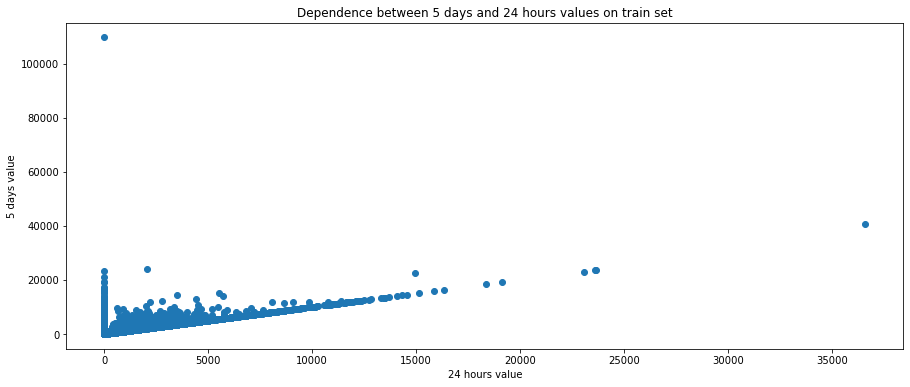

In [224]:
plt.figure(figsize=(15, 6))
plt.scatter(features['24h_value'].values, features['5day_value'].values)
plt.xlabel('24 hours value')
plt.ylabel('5 days value')
plt.title('Dependence between 5 days and 24 hours values on train set')

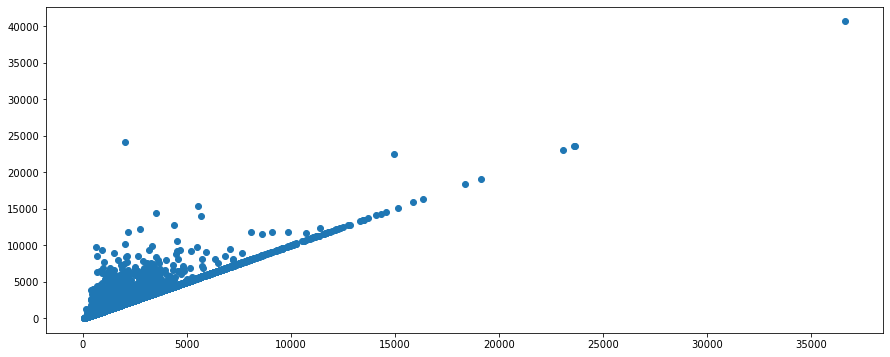

In [39]:
plt.figure(figsize=(15, 6))
tmp = features[features['24h_value'] > 0.]
plt.scatter(tmp['24h_value'].values, tmp['5day_value'].values)

We can see that there are a lot of customers who didn't buy anything else after first 24 hours. So we'll try linear regression first

## Linear regression

In [53]:
# scaler = preprocessing.StandardScaler().fit(X_train)
# scaler = preprocessing.MinMaxScaler().fit(X_train)

In [246]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1000.).fit(X_train, y_train)

In [247]:
a = y_train
b = reg.predict(X_train).clip(min=0)
print('R^2:', r2_score(a, b), 'RMSE:', sqrt(mean_squared_error(a, b)))

R^2: 0.617044382169468 RMSE: 452.5494867456751


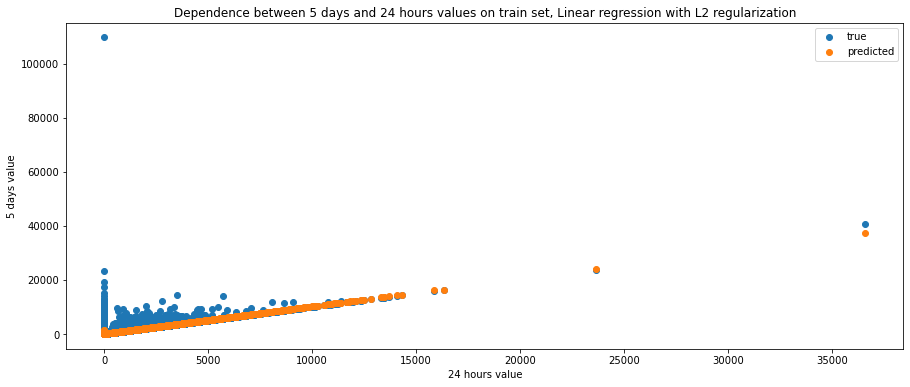

In [248]:
plt.figure(figsize=(15, 6))
plt.scatter(X_train[:, 0], a, label='true')
plt.scatter(X_train[:, 0], b, label='predicted')
plt.xlabel('24 hours value')
plt.ylabel('5 days value')
plt.title('Dependence between 5 days and 24 hours values on train set, Linear regression with L2 regularization')
plt.legend()

As we can see it doesn't work for other customers at all. Let's try boosting to find non-linear dependencies

## Boosting

In [200]:
from xgboost.sklearn import XGBRegressor

Let's find optimal number of estimators

In [192]:
estimators = [10, 20, 50, 70, 100, 150, 200]
training_r2, test_r2, training_rmse, test_rmse = [], [], [], []

scaler = preprocessing.StandardScaler().fit(X_train)
#customers who made other purchases after 24h are particularly interesting, so we weight them more
weight = np.ones(len(X_train)) + (y_train > X_train[:, 0]) * 1.0

for estimator in estimators:
    reg = XGBRegressor(n_estimators=estimator).fit(scaler.transform(X_train), y_train, sample_weight=weight)
    
    a = y_train
    b = reg.predict(scaler.transform(X_train)).clip(min=0)
    training_r2.append(r2_score(a, b))
    training_rmse.append(sqrt(mean_squared_error(a, b)))

    a = y_test
    b = reg.predict(scaler.transform(X_test)).clip(min=0)
    test_r2.append(r2_score(a, b))
    test_rmse.append(sqrt(mean_squared_error(a, b)))

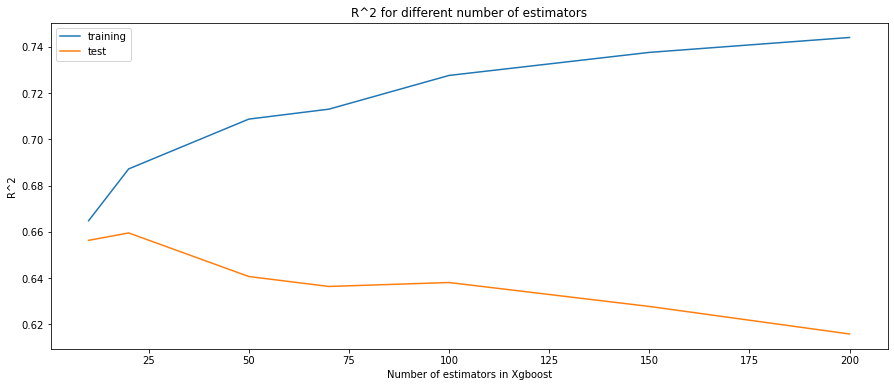

In [207]:
plt.figure(figsize=(15, 6))
plt.plot(estimators, training_r2, label='training')
plt.plot(estimators, test_r2, label='test')
plt.xlabel('Number of estimators in Xgboost')
plt.ylabel('R^2')
plt.title('R^2 for different number of estimators')
plt.legend()

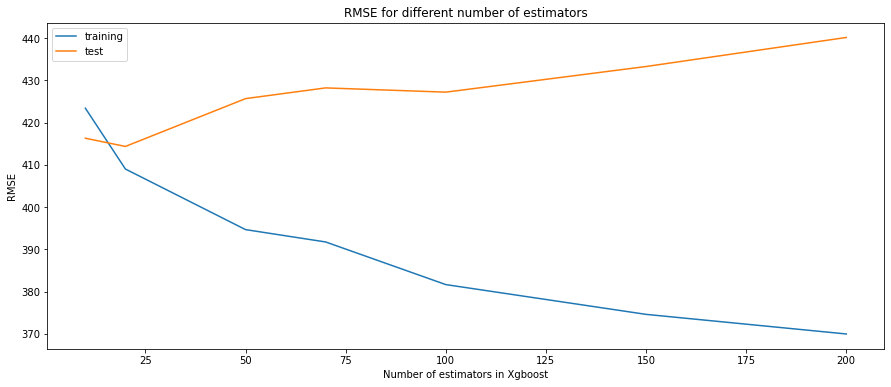

In [208]:
plt.figure(figsize=(15, 6))
plt.plot(estimators, training_rmse, label='training')
plt.plot(estimators, test_rmse, label='test')
plt.xlabel('Number of estimators in Xgboost')
plt.ylabel('RMSE')
plt.title('RMSE for different number of estimators')
plt.legend()

So, we choose 25 estimators

In [219]:
weight = np.ones(len(X_train)) + (y_train > X_train[:, 0]) * 1.0
scaler = preprocessing.StandardScaler().fit(X_train)
reg = XGBRegressor(n_estimators=25).fit(scaler.transform(X_train), y_train, sample_weight=weight)

In [220]:
a = y_train
b = reg.predict(scaler.transform(X_train)).clip(min=0)
print('R^2:', r2_score(a, b), 'RMSE:', sqrt(mean_squared_error(a, b)))

R^2: 0.6893144127929618 RMSE: 407.6171119438182


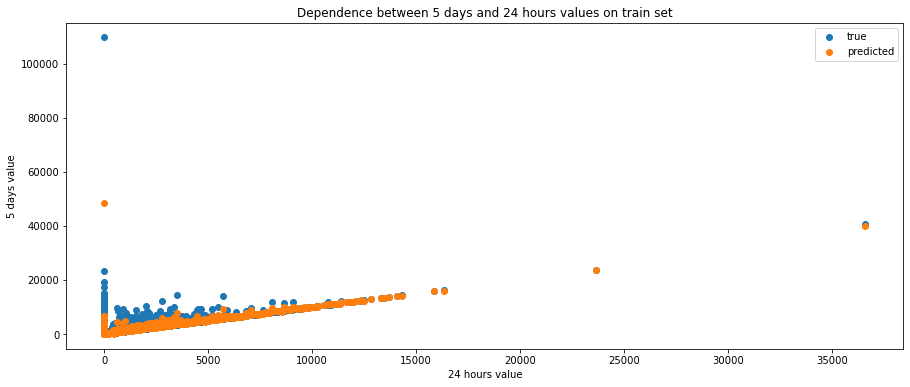

In [216]:
plt.figure(figsize=(15, 6))
plt.scatter(X_train[:, 0], a, label='true')
plt.scatter(X_train[:, 0], b, label='predicted')
plt.xlabel('24 hours value')
plt.ylabel('5 days value')
plt.title('Dependence between 5 days and 24 hours values on train set')
plt.legend()

In [221]:
a = y_test
b = reg.predict(scaler.transform(X_test)).clip(min=0)
print('R^2:', r2_score(a, b), 'RMSE:', sqrt(mean_squared_error(a, b)))

R^2: 0.6584464888172972 RMSE: 414.9924195695419


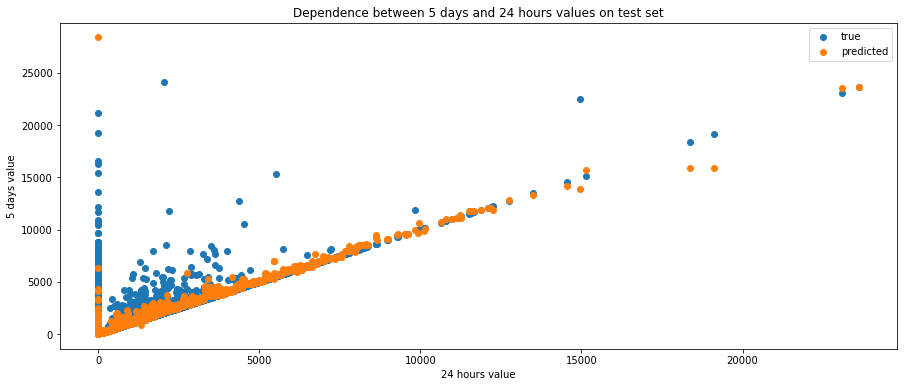

In [222]:
plt.figure(figsize=(15, 6))
plt.scatter(X_test[:, 0], a, label='true')
plt.scatter(X_test[:, 0], b, label='predicted')
plt.xlabel('24 hours value')
plt.ylabel('5 days value')
plt.title('Dependence between 5 days and 24 hours values on test set')
plt.legend()

# Conclusion

Xgboost works well for customers who didn't buy much more in next four days than in the first 24 hours, but it doesn't work in other cases. Overall, RMSE is $4\$$ when median non-zero value is $13\$$ which looks pretty good.

I tried Kernel Ridge Regression and SVM, but both of them require too much RAM for such a big dataset so I didn't manage to run it.

I also tried to divide all customers into two groups: those who bought something in 24 hours and those who didn't, and predicted value for those groups separately (although second group didn't by anything in 24 hours, they made biggest purchases, so maybe they behave differently). But results were worse.

As alternative I would also try some neural networks, maybe it will better capture nonlinear dependencies, but need more time for that.